<a href="https://colab.research.google.com/github/swicklund/hackathon/blob/main/MLModel1-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq fastbook
!pip install dtreeviz
!gcloud config set project {'hackathon-352519'}

import os

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import fastbook as fastai
import pandas as pd
from pandas.io.json import json_normalize
import seaborn as sns
import tensorflow as tf
import json
import zipfile
from io import BytesIO
import torch
import math
from google.colab import files
from google.colab import auth
from datetime import datetime, timedelta

fastai.setup_book()
from fastai import tabular


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Updated property [core/project].


In [2]:
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [3]:
auth.authenticate_user()

In [4]:
# !gcloud config set project {'hackathon-352519'}

In [5]:
#filename = "train-data_all-train-events.zip"
filename = "train-data-2022062020220626.zip"

In [6]:
!gsutil cp gs://trains_data/$filename /tmp/.

Copying gs://trains_data/train-data-2022062020220626.zip...
/ [1 files][192.2 MiB/192.2 MiB]                                                
Operation completed over 1 objects/192.2 MiB.                                    


In [7]:
trains = {}
i = 1
# prevLoco = ''
with zipfile.ZipFile("/tmp/"+filename, "r") as f:
    for name in f.namelist():
        if name.endswith('.json'):
            with f.open(name) as zd:
                data = json.load(zd)
                lastTrainReporting = data['lastTrainReporting']
                currentLoco = lastTrainReporting['ptcLeadLocomotiveId']
                # prevLoco != currentLoco and 
                if ("trainActualPositionList" in lastTrainReporting and len(lastTrainReporting['trainActualPositionList']) > 0): 
                    # trainActualPositionList = lastTrainReporting['trainActualPositionList']
                    trains[i] = pd.json_normalize(lastTrainReporting)
                    i = i + 1
                    if (i % 1000 == 0):
                      current_time = datetime.now().strftime("%H:%M:%S")
                      print(i, " ", current_time)
                    # prevLoco = currentLoco
                            

1000   20:16:30
2000   20:16:38
3000   20:16:50
4000   20:16:55
5000   20:17:01
6000   20:17:05
7000   20:17:10
8000   20:17:16
9000   20:17:20
10000   20:17:25
11000   20:17:30
12000   20:17:37
13000   20:17:43
14000   20:17:49
15000   20:17:55
16000   20:17:59
17000   20:18:05
18000   20:18:09
19000   20:18:13
20000   20:18:19
21000   20:18:25
22000   20:18:32
23000   20:18:36
24000   20:18:40
25000   20:18:47
26000   20:18:51
27000   20:18:55
28000   20:19:04
29000   20:19:08
30000   20:19:12
31000   20:19:16
32000   20:19:24
33000   20:19:27


In [8]:
dfTrainsAll = pd.concat(trains.values())
dfTrainsAll["milepost"] = dfTrainsAll.apply(lambda row: math.trunc(row['lastReportedPosition.milepostLocation.milepost.milepostNumber']), axis=1)

In [9]:
del trains

In [10]:
print(dfTrainsAll.info())
print(dfTrainsAll.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33632 entries, 0 to 0
Data columns (total 37 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   ptcLeadLocomotiveId                                            33632 non-null  object 
 1   positionHistoryList                                            33632 non-null  object 
 2   locomotiveList                                                 33632 non-null  object 
 3   subdivisionList                                                33632 non-null  object 
 4   trainEstimatedPositionList                                     33632 non-null  object 
 5   trainActualPositionList                                        33632 non-null  object 
 6   trainId.trainSCAC                                              33632 non-null  object 
 7   trainId.trainSection                                          

In [11]:
dfTrainsLearn = dfTrainsAll

In [12]:
dfTrainsLearn['loadedCarCount'] =  dfTrainsLearn['loadedCarCount'].replace(np.nan, 999.)
dfTrainsLearn['emptyCarCount'] =  dfTrainsLearn['emptyCarCount'].replace(np.nan, 999.)
dfTrainsLearn['trainLength'] =  dfTrainsLearn['trainLength'].replace(np.nan, 99999.)
dfTrainsLearn['trailingTonnage'] =  dfTrainsLearn['trailingTonnage'].replace(np.nan, 99999.)
# print(dfTrainsLearn['trailingTonnage'].unique())

In [13]:
dfTrainsLearn['mpIncr'] = dfTrainsLearn.apply(lambda row: row['lastReportedPosition.speedMPH'] >= 0, axis=1)

In [39]:
dfTrainsLearn['lastReportedPosition.speedMPH']  = dfTrainsLearn.apply(lambda row: abs(row['lastReportedPosition.speedMPH']), axis=1)
dfTrainsLearn['maximumTrainSpeed']  = dfTrainsLearn.apply(lambda row: abs(row['maximumTrainSpeed']), axis=1)

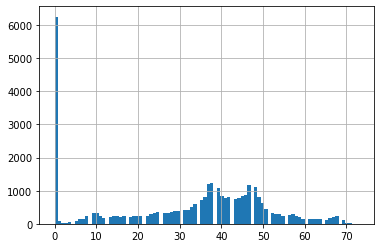

In [40]:
dfTrainsLearn['lastReportedPosition.speedMPH'].hist(bins=90)

In [16]:
aotuColumns = [item for item in dfTrainsLearn.columns if item.startswith('aotu')]
for column in aotuColumns:
  dfTrainsLearn[column] =  dfTrainsLearn[column].replace(np.nan, 0.)

In [17]:
dfTrainsLearn['symbolType'] = dfTrainsLearn.apply(lambda row: row['trainId.trainSymbol'][:1], axis=1)
print(dfTrainsLearn['symbolType'].unique())

['A' 'Q' 'M' 'H' 'G' 'U' 'O' 'I' 'E' 'C' 'Y' 'L' 'Z' 'S' 'R' 'W']


In [18]:
dfTrainsLearn['lastReportedPosition.milepostLocation.trackName'] = dfTrainsLearn['lastReportedPosition.milepostLocation.trackName'].astype('category')
dfTrainsLearn['lastReportedPosition.milepostLocation.trackName'] = dfTrainsLearn['lastReportedPosition.milepostLocation.trackName'].cat.set_categories(['WEST MAIN', 'MAIN', 'MT 2', 'MT 1', 'WESTXO', 'XO', 'EASTXO','YD LD', 'EAST MAIN', 'TO_N_EAST MAIN', 'TO_S_UP_MAINLINE', 'TO_S_CS JUNCTION', 'S_STARKS', 'TO_S_KCS UP PRT CONN', 'TO_N_LUCAS', 'S_LUCAS'])
#dfTrainsLearn['lastReportedSpeedMPH'] = dfTrainsLearn.apply(lambda row: row['positionHistoryList'][0]['speedMPH'], axis=1)
dfTrainsLearn['symbolType'] = dfTrainsLearn['symbolType'].astype('category')
dfTrainsLearn['symbolType'] = dfTrainsLearn['symbolType'].cat.set_categories(['A' 'Q' 'M' 'H' 'G' 'U' 'O' 'I' 'E' 'C' 'Y' 'L' 'Z' 'S' 'R' 'W'])


In [19]:
dfTrainsLearn['maximumTrainSpeed'] =  dfTrainsLearn['maximumTrainSpeed'].replace(np.nan, 88.)
print(dfTrainsLearn['maximumTrainSpeed'].unique())

[88. 50. 60. 70. 40. 45.]


In [20]:
def getWorkLocations(dfTrainsLocation):
  if isinstance(dfTrainsLocation['aotuTrainData.routeLocationList'], float):
    return None
  if len(dfTrainsLocation['aotuTrainData.routeLocationList']) == 0:
    return None
  aotuRoute=pd.json_normalize(dfTrainsLocation['aotuTrainData.routeLocationList']) 
  eventLocations = aotuRoute[aotuRoute['activityList'].map(len) > 1]
  temp = eventLocations['milepost.milepostNumber'].unique()
  if len(temp) == 0:
    return None
  return ','.join(['%.2f' % num for num in temp])

In [21]:
# routeLoca = dfTrainsLearn.loc[dfTrainsLearn['aotuTrainData.routeLocationList'].str.len() > 0]['aotuTrainData.routeLocationList']
# route = routeLoca.iloc[0]
# print(route)
# jsroute = pd.json_normalize(route)
# jsroute

In [22]:
# dfTrainsLearn.loc[dfTrainsLearn['aotuTrainData.routeLocationList'].map(len)==0]
# dfTrainsLearn[dfTrainsLearn['aotuTrainData.routeLocationList'].apply(lambda x: isinstance(x, float))]['aotuTrainData.routeLocationList']

In [23]:
dfTrainsLearn['workLocations'] = dfTrainsLearn.apply(lambda row: getWorkLocations(row), axis=1)

In [24]:
dfTrainsLearn['workLocations'].unique()

array([None, '225.10', '202.20', '202.20,219.70', '250.50,202.20', '258.40,202.20', '202.20,258.40,321.50', '202.20,258.40', '219.70,202.20', '202.20,314.52', '202.20,214.50,225.10,290.80,304.10',
       '214.50,225.10,290.80,304.10,202.20', '321.50,202.20', '321.50,314.52,202.20', '258.40,219.70,202.20', '314.52,202.20', '258.40,207.60,202.20', '257.60,202.20', '202.20,265.30',
       '202.20,258.40,318.90,321.50', '202.20,258.40,321.50,219.70', '202.20,219.70,258.40,321.50', '202.20,219.70,250.50,258.40,321.50', '202.20,219.70,258.40', '225.10,202.20'], dtype=object)

We can make this more clever later, but for now this seems the most sensible shortcut

In [25]:
dfTrainsLearn['locomotiveCount'] = dfTrainsLearn.apply(lambda row: len(row['locomotiveList']),axis = 1)

In [26]:
dfTrainsLearnActuals = dfTrainsLearn.apply(lambda row: pd.json_normalize(row['trainActualPositionList']), axis=1)

In [27]:
dfTrainsLearnActuals.iloc[1]

,positionTime,speedMPH,milepostLocation.subdivisionId,milepostLocation.trackName,milepostLocation.milepost.milepostNumber
0,2022-06-20T21:45:28Z,11,106,MAIN,765.4883
1,2022-06-20T21:47:28Z,14,106,MAIN-WEST MAIN,765.9972


In [28]:
dfTrainsLearn = dfTrainsLearn.reset_index(drop=True)

In [43]:
def findNextSpeed(trainsEntry, actualsEntry):
  milepost = trainsEntry['lastReportedPosition.milepostLocation.milepost.milepostNumber']
  #print(milepost)
  value  = actualsEntry.loc[actualsEntry['milepostLocation.milepost.milepostNumber'] > milepost+1]
  if (len(value) > 0):
    mp = value.min()
    amt = (abs(mp['speedMPH']) - abs(trainsEntry['lastReportedPosition.speedMPH']))
    if (abs(amt) > 60):
      print("Whoa: ",trainsEntry['trainId.trainSymbol'],trainsEntry['trainId.trainDate'],": " , abs(trainsEntry['lastReportedPosition.speedMPH'])," to ", abs(mp['speedMPH']))
    return amt;
  value  = actualsEntry.loc[actualsEntry['milepostLocation.milepost.milepostNumber'] < milepost-1]
  if (len(value) > 0):
    mp = value.max()
    amt = (abs(mp['speedMPH']) - abs(trainsEntry['lastReportedPosition.speedMPH']))
    if (abs(amt) > 60):
      print("Whoa: ",trainsEntry['trainId.trainSymbol'],trainsEntry['trainId.trainDate'],": " , abs(trainsEntry['lastReportedPosition.speedMPH'])," to ", abs(mp['speedMPH']))
    return amt;
  return None

In [44]:
dfTrainsLearn['nextSpeed'] = dfTrainsLearn['lastReportedPosition.speedMPH']
i = 0;
for index, trainsEntry in dfTrainsLearn.iterrows():
  actualsEntry = dfTrainsLearnActuals.iloc[i]
  nextSpeed = findNextSpeed(trainsEntry, actualsEntry)
  if (nextSpeed != None):
    dfTrainsLearn.at[i,'nextSpeed'] = nextSpeed
  if (i % 1000 == 0):
    print(i)
  i = i + 1

0
1000
2000
3000
Whoa:  ZBRG2B 2022-06-20 :  61  to  0
Whoa:  ZBRG2B 2022-06-20 :  63  to  0
Whoa:  ZBRG2B 2022-06-20 :  68  to  0
Whoa:  ZBRG2B 2022-06-20 :  71  to  0
Whoa:  ZBRG2B 2022-06-20 :  71  to  0
Whoa:  ZBRG2B 2022-06-20 :  69  to  0
Whoa:  ZBRG2B 2022-06-20 :  68  to  0
Whoa:  ZBRG2B 2022-06-20 :  68  to  0
Whoa:  ZBRG2B 2022-06-20 :  63  to  0
Whoa:  ZBRG2B 2022-06-20 :  61  to  0
Whoa:  ZBRG2B 2022-06-20 :  63  to  0
Whoa:  ZBRG2B 2022-06-20 :  69  to  0
Whoa:  ZBRG2B 2022-06-20 :  71  to  0
Whoa:  ZBRG2B 2022-06-20 :  70  to  0
Whoa:  ZBRG2B 2022-06-20 :  71  to  0
Whoa:  ZBRG2B 2022-06-20 :  71  to  0
Whoa:  ZBRG2B 2022-06-20 :  69  to  0
Whoa:  ZBRG2B 2022-06-20 :  68  to  0
Whoa:  ZBRG2B 2022-06-20 :  61  to  0
Whoa:  ZBRG2B 2022-06-20 :  64  to  0
Whoa:  ZBRG2B 2022-06-20 :  69  to  0
Whoa:  ZBRG2B 2022-06-20 :  71  to  0
Whoa:  ZBRG2B 2022-06-20 :  70  to  0
Whoa:  ZBRG2B 2022-06-20 :  64  to  0
Whoa:  ZBRG2B 2022-06-20 :  61  to  0
Whoa:  ZBRG2B 2022-06-20 :  62  t

In [45]:
# dfTrainsLearn = dfTrainsLearn.drop(['hour'], axis=1)
dfTrainsLearn['nextSpeed'].unique()

array([  9,   4,   6,  18,  19,  -8,  -1,  21,  -6,  20,  15, -10,  -9,   0,  -2,  10,   1,  -4,  -3,   7,   5,   2,   8,  11,   3,  12,  13,  16,  14, -13, -31, -28, -25, -30, -27,  22, -11, -26,
       -29, -33, -22, -23, -34, -17,  17,  -5, -16, -15,  -7, -12, -18, -24, -45, -48, -42, -36, -40, -47, -50, -49, -46, -39, -41, -44, -35, -14, -37, -38, -51, -43, -19, -32,  24,  23, -20,  30,
        26, -21,  29,  27,  33, -52, -58, -59, -53, -56, -57,  25,  28, -55, -54, -60, -61, -63, -68, -71, -69, -70, -64, -62, -67,  34,  37,  36,  32,  31, -65, -66,  38,  44,  39,  45,  65,  62,
        35,  41,  40])

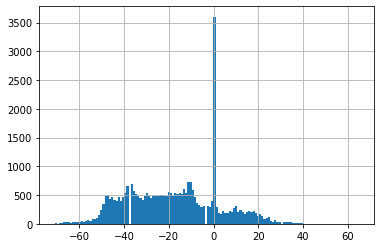

In [46]:
dfTrainsLearn['nextSpeed'].hist(bins=140)

Drop some values we are not using at the moment not needed

In [47]:
dfTrainsLearn = dfTrainsLearn.drop(columns=['aotuTrainData.tenantCarrier',
                                            # 'lastReportedPosition.precedingSignalState.currentStateTime', 
                                            # 'lastReportedPosition.nextSignalState.previousSignalState', 
                                            # 'lastReportedPosition.nextSignalState.currentStateTime', 
                                            'positionHistoryList',
                                            'locomotiveList',
                                            'subdivisionList',
                                            'trainActualPositionList',
                                            'trainEstimatedPositionList'
                                            ,'aotuTrainData.routeLocationList'])

In [48]:
tabular.core.make_date(dfTrainsLearn, 'trainId.trainDate')
tabular.core.make_date(dfTrainsLearn, 'lastReportedPosition.positionTime')
tabular.core.add_datepart(dfTrainsLearn, 'lastReportedPosition.positionTime')
# tabular.core.add_elapsed_times(dfTrainsLearn, 'lastReportedPosition.positionTime')


,ptcLeadLocomotiveId,trainId.trainSCAC,trainId.trainSection,trainId.trainSymbol,...,lastReportedPosition.positionTimeIs_quarter_start,lastReportedPosition.positionTimeIs_year_end,lastReportedPosition.positionTimeIs_year_start,lastReportedPosition.positionTimeElapsed
0,AMTK179,UP,,AMT1,...,False,False,False,1.655761e+09
1,AMTK179,UP,,AMT1,...,False,False,False,1.655761e+09
2,AMTK179,UP,,AMT1,...,False,False,False,1.655761e+09
3,AMTK186,UP,,AMT1,...,False,False,False,1.655938e+09
4,AMTK186,UP,,AMT1,...,False,False,False,1.655938e+09
...,...,...,...,...,...,...,...,...,...
33627,UP9101,UP,,MCHCB,...,False,False,False,1.655985e+09
33628,UP9101,UP,,MCHCB,...,False,False,False,1.655985e+09
33629,UP9101,UP,,MCHCB,...,False,False,False,1.655985e+09
33630,UP9101,UP,,MCHCB,...,False,False,False,1.655985e+09


In [49]:
print(dfTrainsLearn.shape)
print(dfTrainsLearnActuals.shape)

print(dfTrainsLearn.info())
print(dfTrainsLearn.iloc[100])

(33632, 47)
(33632,)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33632 entries, 0 to 33631
Data columns (total 47 columns):
 #   Column                                                         Non-Null Count  Dtype         
---  ------                                                         --------------  -----         
 0   ptcLeadLocomotiveId                                            33632 non-null  object        
 1   trainId.trainSCAC                                              33632 non-null  object        
 2   trainId.trainSection                                           33632 non-null  object        
 3   trainId.trainSymbol                                            33632 non-null  object        
 4   trainId.trainDate                                              33632 non-null  datetime64[ns]
 5   lastReportedPosition.speedMPH                                  33632 non-null  int64         
 6   lastReportedPosition.milepostLocation.subdivisionId            33632 non-

# Use Decision Tree to predict speed in 1 mile

In [50]:
procs = [tabular.core.Categorify, tabular.core.FillMissing]

In [51]:
print (dfTrainsLearn.groupby(['lastReportedPosition.positionTimeDayofyear'])['lastReportedPosition.positionTimeDayofyear'].count())


lastReportedPosition.positionTimeDayofyear
171    4171
172    4497
173    4401
174    5555
175    4999
176    4597
177    4867
178     545
Name: lastReportedPosition.positionTimeDayofyear, dtype: int64


In [52]:
cond = ( dfTrainsLearn['lastReportedPosition.positionTimeDayofyear'] < 176 )
trainIdx = np.where(cond)[0]
validIdx = np.where(~cond)[0]
splits = (list(trainIdx), list(validIdx))

In [53]:
dep_var = 'nextSpeed'

In [54]:
cont,cat = tabular.core.cont_cat_split(dfTrainsLearn, 1, dep_var=dep_var)

In [55]:
to = tabular.core.TabularPandas(dfTrainsLearn, procs, cat, cont, y_names=dep_var, splits=splits)

In [56]:
len(to.train),len(to.valid)

(23623, 10009)

In [57]:
to.show()

,ptcLeadLocomotiveId,trainId.trainSCAC,trainId.trainSection,trainId.trainSymbol,trainId.trainDate,lastReportedPosition.milepostLocation.subdivisionId,lastReportedPosition.milepostLocation.trackName,mpIncr,symbolType,workLocations,lastReportedPosition.positionTimeYear,lastReportedPosition.positionTimeMonth,lastReportedPosition.positionTimeIs_month_end,lastReportedPosition.positionTimeIs_month_start,lastReportedPosition.positionTimeIs_quarter_end,lastReportedPosition.positionTimeIs_quarter_start,lastReportedPosition.positionTimeIs_year_end,lastReportedPosition.positionTimeIs_year_start,lastReportedPosition.speedMPH,lastReportedPosition.milepostLocation.milepost.milepostNumber,aotuTrainData.priorityCode,aotuTrainData.categoryCode,aotuTrainData.authorityRangeCode,aotuTrainData.ownershipCode,aotuTrainData.totalCarWeight,aotuTrainData.totalCarLength,aotuTrainData.totalLocomotiveWeight,aotuTrainData.totalLocomotiveLength,aotuTrainData.actualTonsPerAxle,aotuTrainData.heavy143TonCarCount,aotuTrainData.heavy158TonCarCount,aotuTrainData.over158TonCarCount,aotuTrainData.highWideCarCount,aotuTrainData.eventCode,maximumTrainSpeed,loadedCarCount,emptyCarCount,trainLength,trailingTonnage,milepost,locomotiveCount,lastReportedPosition.positionTimeWeek,lastReportedPosition.positionTimeDay,lastReportedPosition.positionTimeDayofweek,lastReportedPosition.positionTimeDayofyear,lastReportedPosition.positionTimeElapsed,nextSpeed
0,AMTK179,UP,,AMT1,2022-06-19,106,TO_S_UP_MAINLINE,True,#na#,#na#,2022,6,False,False,False,False,False,False,9,764.869629,1.0,14.0,2.0,3.0,9820000.0,61200.0,5360000.0,16560.0,65535.0,0.0,0.0,0.0,0.0,0.0,88.0,999.0,999.0,99999.0,99999.0,764,0,25,20,0,171,1.655761e+09,9
1,AMTK179,UP,,AMT1,2022-06-19,106,MAIN,True,#na#,#na#,2022,6,False,False,False,False,False,False,10,764.986572,1.0,14.0,2.0,3.0,4460000.0,61200.0,5360000.0,16560.0,65535.0,0.0,0.0,0.0,0.0,0.0,88.0,999.0,999.0,99999.0,99999.0,764,0,25,20,0,171,1.655761e+09,4
2,AMTK179,UP,,AMT1,2022-06-19,106,MAIN,True,#na#,#na#,2022,6,False,False,False,False,False,False,10,764.994873,1.0,14.0,2.0,3.0,4460000.0,61200.0,5360000.0,16560.0,65535.0,0.0,0.0,0.0,0.0,0.0,88.0,999.0,999.0,99999.0,99999.0,764,0,25,20,0,171,1.655761e+09,4
3,AMTK186,UP,,AMT1,2022-06-21,106,TO_S_UP_MAINLINE,True,#na#,#na#,2022,6,False,False,False,False,False,False,8,764.869080,1.0,14.0,2.0,3.0,7140000.0,61200.0,5360000.0,16560.0,65535.0,0.0,0.0,0.0,0.0,0.0,88.0,999.0,999.0,99999.0,99999.0,764,0,25,22,2,173,1.655938e+09,9
4,AMTK186,UP,,AMT1,2022-06-21,106,MAIN,True,#na#,#na#,2022,6,False,False,False,False,False,False,10,764.987610,1.0,14.0,2.0,3.0,7140000.0,61200.0,5360000.0,16560.0,65535.0,0.0,0.0,0.0,0.0,0.0,88.0,999.0,999.0,99999.0,99999.0,764,0,25,22,2,173,1.655938e+09,6
5,AMTK186,UP,,AMT1,2022-06-21,106,MAIN,True,#na#,#na#,2022,6,False,False,False,False,False,False,10,764.996582,1.0,14.0,2.0,3.0,7140000.0,61200.0,5360000.0,16560.0,65535.0,0.0,0.0,0.0,0.0,0.0,88.0,999.0,999.0,99999.0,99999.0,764,0,25,22,2,173,1.655938e+09,6
6,AMTK186,UP,,AMT1,2022-06-21,106,MAIN,True,#na#,#na#,2022,6,False,False,False,False,False,False,18,765.940796,1.0,14.0,2.0,3.0,7140000.0,61200.0,5360000.0,16560.0,65535.0,0.0,0.0,0.0,0.0,0.0,88.0,999.0,999.0,99999.0,99999.0,765,0,25,22,2,173,1.655938e+09,18
7,AMTK186,UP,,AMT1,2022-06-21,106,TO_N_EAST MAIN,True,#na#,#na#,2022,6,False,False,False,False,False,False,19,766.128174,1.0,14.0,2.0,3.0,7140000.0,61200.0,5360000.0,16560.0,65535.0,0.0,0.0,0.0,0.0,0.0,88.0,999.0,999.0,99999.0,99999.0,766,0,25,22,2,173,1.655938e+09,19
8,AMTK186,UP,,AMT2,2022-06-19,106,WEST MAIN,False,#na#,#na#,2022,6,False,False,False,False,False,False,18,766.930176,1.0,14.0,2.0,3.0,9820000.0,77760.0,5360000.0,16560.0,65535.0,0.0,0.0,0.0,0.0,0.0,88.0,999.0,999.0,99999.0,99999.0,766,0,25,22,2,173,1.655857e+09,-8
9,AMTK186,UP,,AMT2,2022-06-19,106,WEST MAIN,False,#na#,#na#,2022,6,False,False,False,False,False,False,19,766.797607,1.0,14.0,2.0,3.0,9820000.0,77760.0,5360000.0,16560.0,65535.0,0.0,0.0,0.0,0.0,0.0,88.0,999.0,

In [58]:
fastai.save_pickle('/tmp/to.pkl',to)

# Creating the Decision Tree

In [59]:
to = fastai.load_pickle('/tmp/to.pkl')

In [60]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [61]:
m = DecisionTreeRegressor(max_leaf_nodes=16)
m.fit(xs, y);

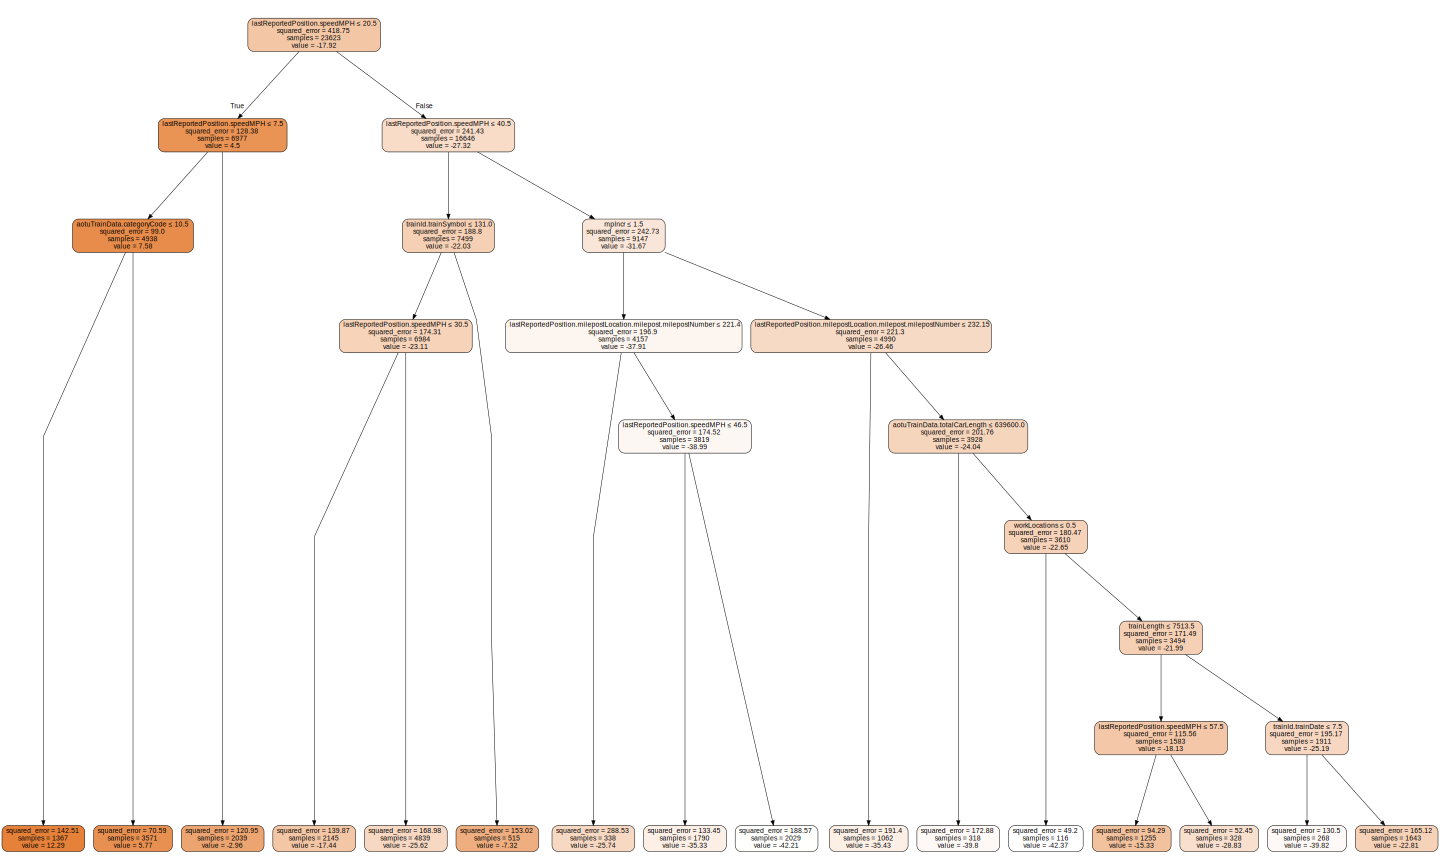

In [62]:
fastai.draw_tree(m, xs, size=20, leaves_parallel=True, precision=2)

In [63]:
m = DecisionTreeRegressor(min_samples_leaf=10)
m.fit(xs, y);

In [64]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [65]:
m_rmse(m, xs, y)

4.569797

In [66]:
m_rmse(m, valid_xs, valid_y)

16.795718

In [67]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [68]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
18,lastReportedPosition.speedMPH,0.633494
19,lastReportedPosition.milepostLocation.milepost.milepostNumber,0.068935
45,lastReportedPosition.positionTimeElapsed,0.047765
3,trainId.trainSymbol,0.044971
7,mpIncr,0.037607
4,trainId.trainDate,0.019190
0,ptcLeadLocomotiveId,0.015381
37,trainLength,0.014140
9,workLocations,0.013605
36,emptyCarCount,0.013377


Our first result! It appears the previous speed is so heavily influencing the next speed, it swamps everything else.

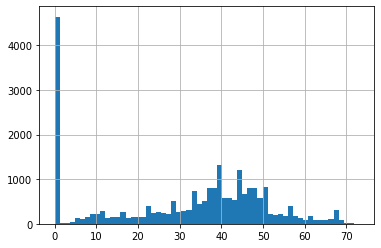

In [69]:
ax = xs['lastReportedPosition.speedMPH'].hist(bins=60)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


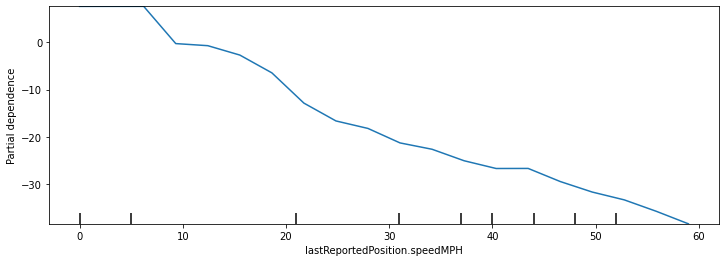

In [70]:
from sklearn.inspection import plot_partial_dependence

fig,ax = plt.subplots(figsize=(12, 4))
plot_partial_dependence(m, xs, ['lastReportedPosition.speedMPH'],
                        grid_resolution=20, ax=ax);

This is sort of a dur moment, saying "Speeds don't change a lot one milepost to the next".  

#Random Forest

In [93]:
def randomForest(xs, y, n_estimators=50, max_samples=2500,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [94]:
m = randomForest(xs, y);

In [95]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(6.846525, 12.728261)

In [ ]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [97]:
r_mse(preds.mean(0), valid_y)

12.728261

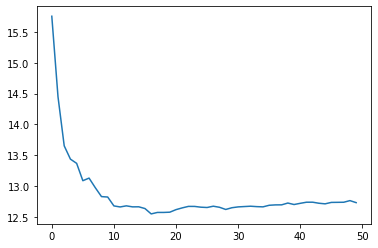

In [98]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(50)]);

### Out-of-Bag Error

In [99]:
r_mse(m.oob_prediction_, y)

7.185803

- How confident are we in our predictions using a particular row of data?
- For predicting with a particular row of data, what were the most important factors, and how did they influence that prediction?
- Which columns are the strongest predictors, which can we ignore?
- Which columns are effectively redundant with each other, for purposes of prediction?
- How do predictions vary, as we vary these columns?


In [ ]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [101]:
preds.shape

(50, 10009)

In [102]:
preds_std = preds.std(0)

In [103]:
preds_std[:5]

array([ 7.44546566, 10.18999771, 11.033761  , 11.27399834, 12.01187671])

In [114]:
print(preds.mean(0)[:10])
print(valid_y[:10])
valid_y

[ 1.54218038 -0.69016667  1.4146746   2.05086508  2.83321429 -0.44680952  4.40793362  4.999386    4.999386    8.68016378]
20    -1
21   -10
22    19
23    19
24    20
25    21
26    -9
27   -10
28   -10
29    19
Name: nextSpeed, dtype: int8


20       -1
21      -10
22       19
23       19
24       20
         ..
33457     7
33458    -3
33459   -12
33460   -16
33461    -8
Name: nextSpeed, Length: 10009, dtype: int8

# FEATURE Importance

In [82]:
fi = rf_feat_importance(m, xs)
fi[:20]

,cols,imp
18,lastReportedPosition.speedMPH,0.542826
7,mpIncr,0.083391
19,lastReportedPosition.milepostLocation.milepost.milepostNumber,0.069671
39,milepost,0.051558
3,trainId.trainSymbol,0.030732
45,lastReportedPosition.positionTimeElapsed,0.029280
38,trailingTonnage,0.017984
25,aotuTrainData.totalCarLength,0.016898
6,lastReportedPosition.milepostLocation.trackName,0.015833
24,aotuTrainData.totalCarWeight,0.015070


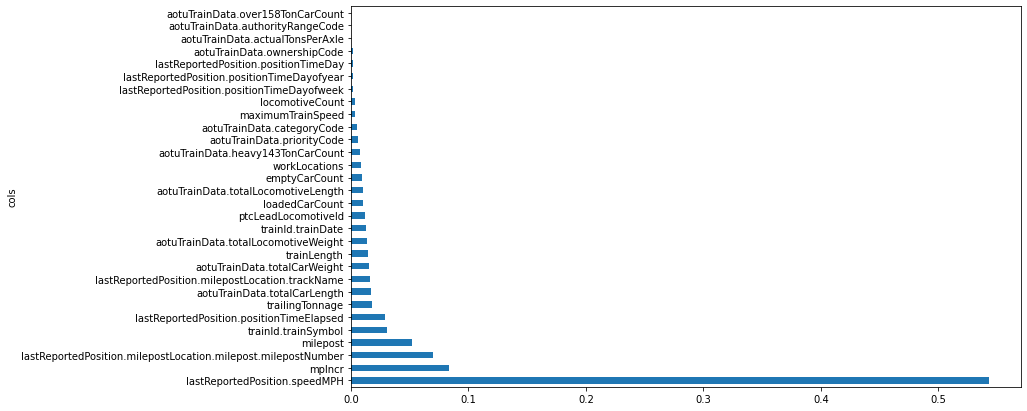

In [83]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

Remove low importance columns

In [84]:
to_keep = fi[fi.imp>0.002].cols
len(to_keep)

25

In [85]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [86]:
m = randomForest(xs_imp, y)

In [87]:
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

(6.89492, 12.572587)

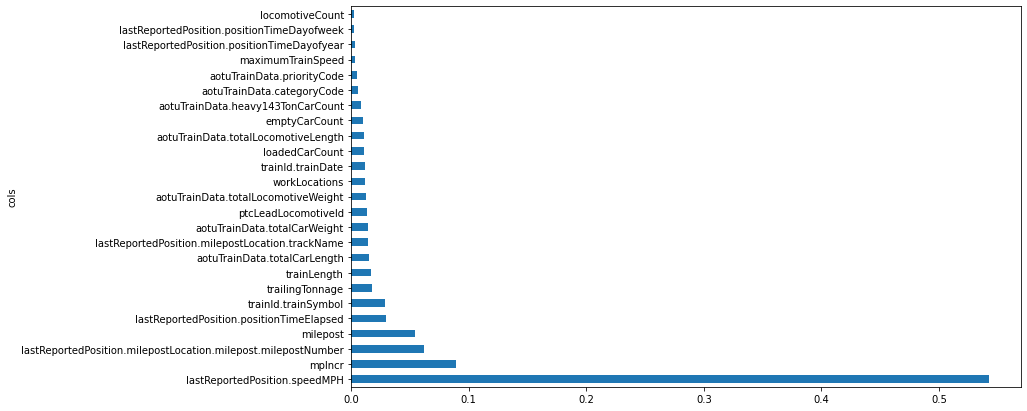

In [88]:
plot_fi(rf_feat_importance(m, xs_imp));

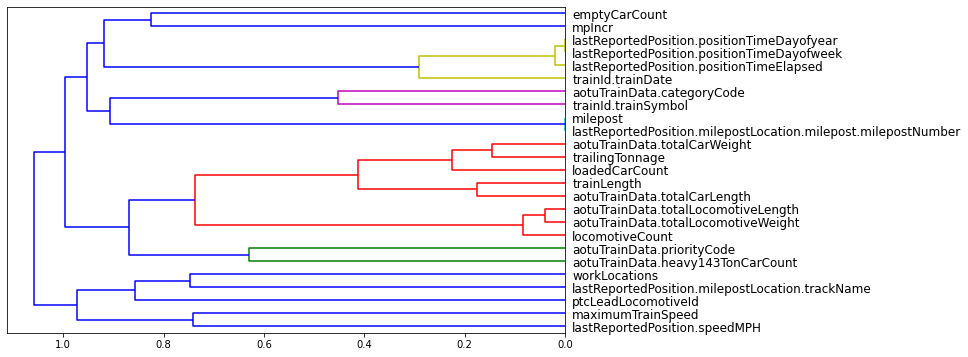

In [89]:
fastai.cluster_columns(xs_imp)